In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import RidgeClassifier
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from functools import wraps
from time import time


In [2]:
def timeit100(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        ts = time()
        for _ in range(100):
            f(*args, **kwargs)
        te = time()
        print(f'{f.__name__}: {(te-ts)/100:08.10f}s')
        return f(*args, **kwargs)
    return wrap

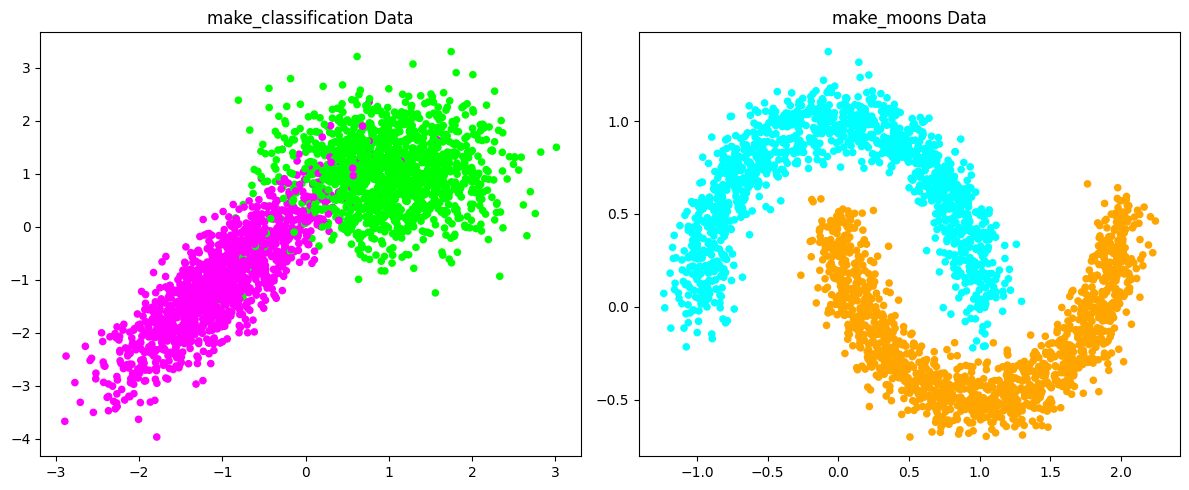

In [3]:
random_state=254493
n_samples = 2593

X_clf, t_clf = make_classification(random_state=random_state, n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X_moons, t_moons = make_moons(random_state=random_state, n_samples=n_samples, noise=0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=np.where(t_clf==0, 'lime', 'magenta'), s=20)
plt.title('make_classification Data')

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=np.where(t_moons==0, 'cyan', 'orange'), s=20)
plt.title('make_moons Data')

plt.tight_layout()
plt.show()


Dzieleie na dane testowe i treningowe


In [4]:
X_train_clf, X_test_clf, t_train_clf, t_test_clf = train_test_split(X_clf, t_clf, test_size=0.2, random_state=random_state)

In [5]:
X_train_moons, X_test_moons, t_train_moons, t_test_moons = train_test_split(X_moons, t_moons, test_size=0.2, random_state=random_state)

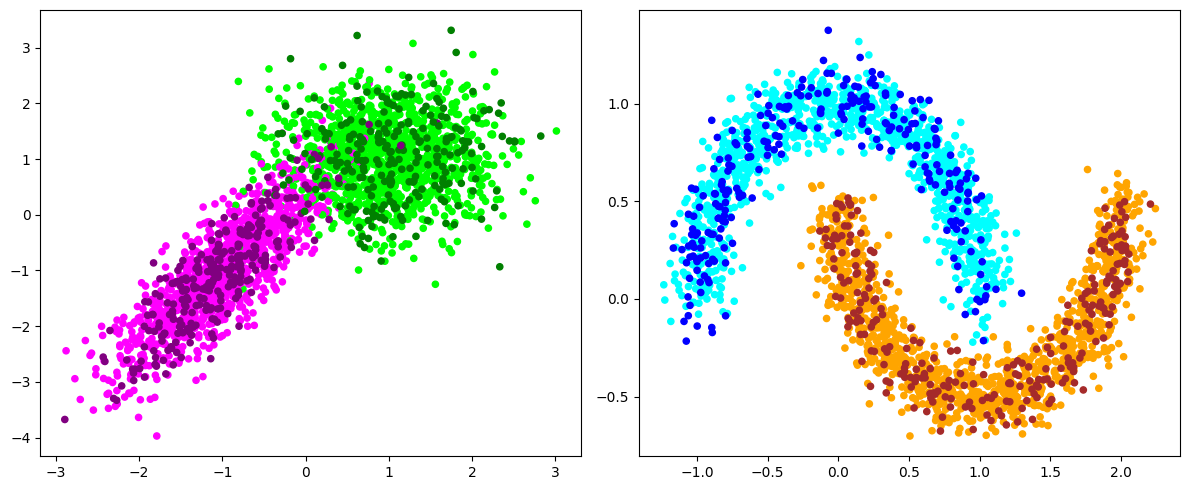

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_clf[:, 0], X_train_clf[:, 1], c=np.where(t_train_clf==0, 'lime', 'magenta'), s=20)
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1], c=np.where(t_test_clf==0, 'green', 'purple'), s=20)


plt.subplot(1, 2, 2)
plt.scatter(X_train_moons[:, 0], X_train_moons[:, 1], c=np.where(t_train_moons==0, 'cyan', 'orange'), s=20)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=np.where(t_test_moons==0, 'blue', 'brown'), s=20)

plt.tight_layout()
plt.show()


In [7]:
X1 = np.array(X_train_clf[t_train_clf == 1])
X2 = np.array(X_train_clf[t_train_clf == 0])
X = np.vstack((X1,X2))
print(X)
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1
print(X)

[[-0.77941372 -1.13233833]
 [-0.27742399 -0.74414029]
 [-0.97613915 -1.02913618]
 ...
 [ 0.92127479  1.75013979]
 [ 0.12259481  1.58006054]
 [ 2.0104975   1.04333992]]
[[-0.77941372 -1.13233833  1.        ]
 [-0.27742399 -0.74414029  1.        ]
 [-0.97613915 -1.02913618  1.        ]
 ...
 [ 0.92127479  1.75013979  1.        ]
 [ 0.12259481  1.58006054  1.        ]
 [ 2.0104975   1.04333992  1.        ]]


In [48]:
def linear_function(Theta, variable):
    return (-Theta[0]*variable-Theta[2])/Theta[1]

In [49]:
Theta = np.linalg.inv(X.T@X + 0.05*np.eye(X.shape[1]))@X.T@t
print(Theta)
x = np.linspace(np.min(X1[:,0]), np.max(X2[:,1]),100)

[0.53095841 0.2007859  0.0062573 ]


In [50]:
def classify_sample(Theta, test_sample):
    x = test_sample[0]
    y = test_sample[1]
    label = test_sample[2]
    function = linear_function(Theta, x)
    if y < function:
        return [[x,y], [label, -1]]
    return [[x,y], [label, 1]]

In [51]:
@timeit100
def classify(Theta, x_test):
    X = []
    for x in x_test:
        result_of_classification = classify_sample(Theta, x)
        X.append([result_of_classification[0], result_of_classification[1], result_of_classification[1][0] == result_of_classification[1][1]])
    return sorted(X, key=lambda v: not v[2])

In [52]:
X_test = [[X_test_clf[i][0], X_test_clf[i][1], -2*t_test_clf[i]+1] for i in range(len(X_test_clf))]
X_res = classify(Theta, X_test)

classify: 0.0005100369s


In [53]:
def plot_classification_result(X_result, Theta, lin_color, c1, c2, variable, xmin, xmax, ymin, ymax, title):
    fig, ax = plt.subplots()
    plt.plot(variable,linear_function(Theta, variable), color=lin_color)
    plt.title(title)
    plt.fill_between(variable, linear_function(Theta, variable), max(linear_function(Theta, variable)), color = c2, alpha=0.2)
    plt.fill_between(variable, linear_function(Theta, variable), min(linear_function(Theta, variable)), color = c1, alpha=0.2)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    for x in X_result:
        
        if x[1][0] == -1:
            color = c1
            bordercolor = c1
        else:
            color = c2
            bordercolor = c2

        if not x[2]:
            bordercolor = 'b'
        plt.scatter(x[0][0], x[0][1], color=color, edgecolor=bordercolor)


In [54]:
def plot_confusion_matrix(true_labels, predicted_labels, cmap, title = 'Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)

    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Czułość (True Positive Rate)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Swoistość (True Negative Rate)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()  # Dokładność (Accuracy)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=['Actual -1', 'Actual 1'],
                     yticklabels=['Predicted -1', 'Predicted 1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)

    text = f'Sensitivity: {sensitivity:.5f}\nSpecificity: {specificity:.5f}\nAccuracy: {accuracy:.5f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.2, 0.5, text, transform=ax.transAxes, fontsize=12, verticalalignment='center', bbox=props)

    plt.show()

In [55]:
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

In [56]:
def plot_ROC(true_labels, predicted_labels, title = 'ROC'):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.fill_between(fpr, tpr, color='cyan', alpha=0.3)  # Jasnożółta powierzchnia pod krzywą
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [57]:
def plot_classification_summary(true_labels, predicted_labels, cmap = 'summer'):
    plot_confusion_matrix(true_labels, np.sign(predicted_labels), cmap)
    plot_ROC(true_labels, predicted_labels)

Wyniki analitycznej klasyfikacji liniowej

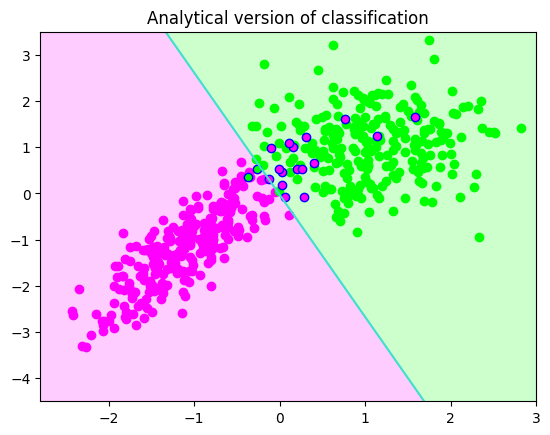

In [58]:
plot_classification_result(X_res, Theta, 'turquoise', 'magenta', 'lime', x, -2.8,3,-4.5,3.5, 'Analytical version of classification')

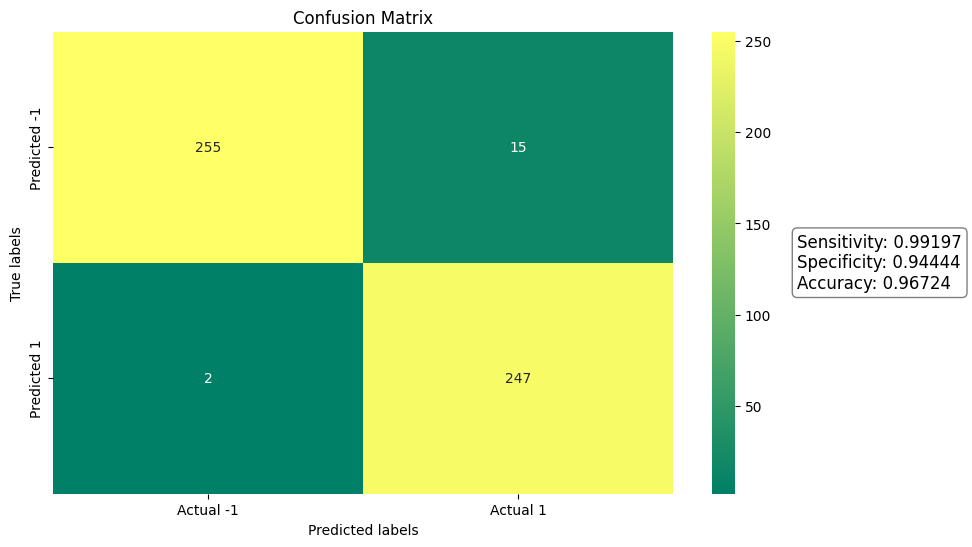

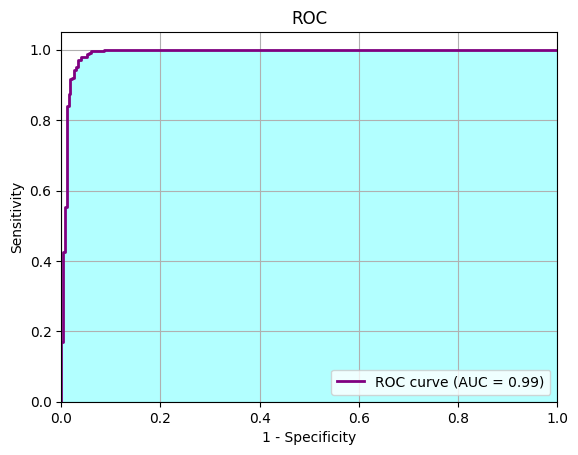

In [59]:
plot_classification_summary(true_labels, predicted_labels)

In [60]:
X1 = np.array(X_train_moons[t_train_moons == 1])
X2 = np.array(X_train_moons[t_train_moons == 0])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1

Theta = np.linalg.inv(X.T@X+0.15*np.eye(X.shape[1]))@X.T@t
print(Theta)
x = np.linspace(-15, 25, 400)
X_test = [[X_test_moons[i][0], X_test_moons[i][1], -2*t_test_moons[i]+1] for i in range(len(X_test_moons))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

[-0.31410525  1.28976843 -0.15976921]
classify: 0.0005355120s


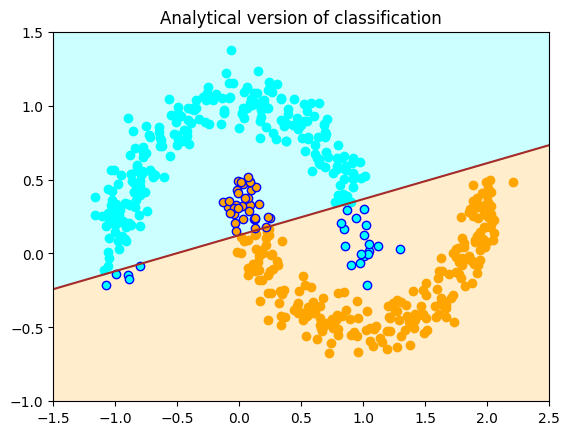

In [61]:
plot_classification_result(X_res, Theta, 'brown', 'orange', 'cyan',x, -1.5, 2.5, -1, 1.5, 'Analytical version of classification')

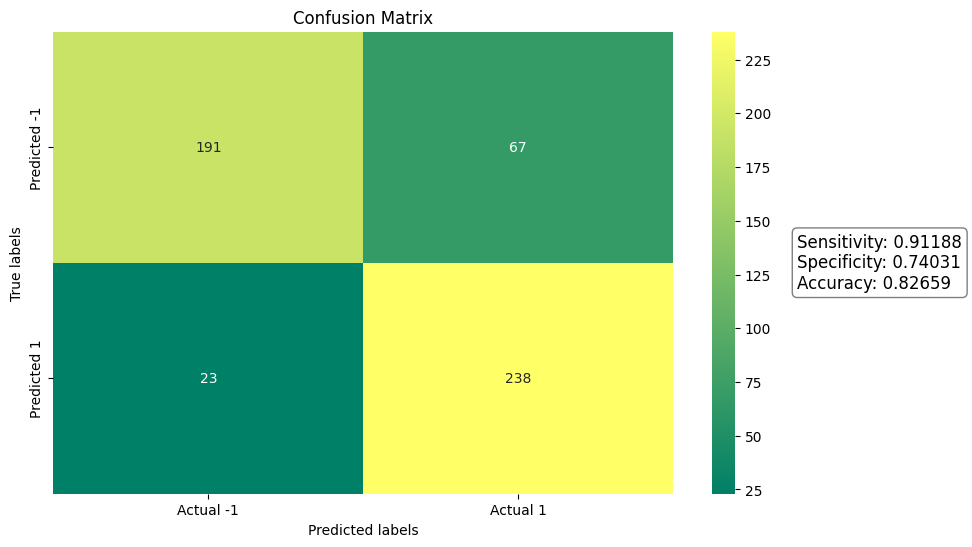

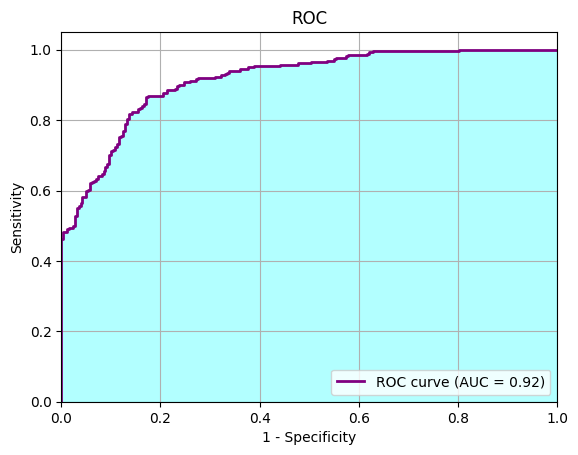

In [62]:
plot_classification_summary(true_labels, predicted_labels)

Wyniki klasyfikacji liniowej z użyciem sklearn.linear_model.RidgeClassifier

In [63]:
X_train_clf, X_test_clf, t_train_clf, t_test_clf = train_test_split(X_clf, t_clf, test_size=0.2, random_state=random_state)
X_train_moons, X_test_moons, t_train_moons, t_test_moons = train_test_split(X_moons, t_moons, test_size=0.2, random_state=random_state)

In [64]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_clf, t_train_clf)

RidgeClassifier()

In [65]:
coef = ridge_classifier.coef_[0]
intercept = ridge_classifier.intercept_

Theta = np.array([-coef[0], -coef[1], -intercept[0]])
Theta

array([0.53057442, 0.20101313, 0.00625564])

In [66]:
X_test = [[X_test_clf[i][0], X_test_clf[i][1], -2*t_test_clf[i]+1] for i in range(len(X_test_clf))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

classify: 0.0006099963s


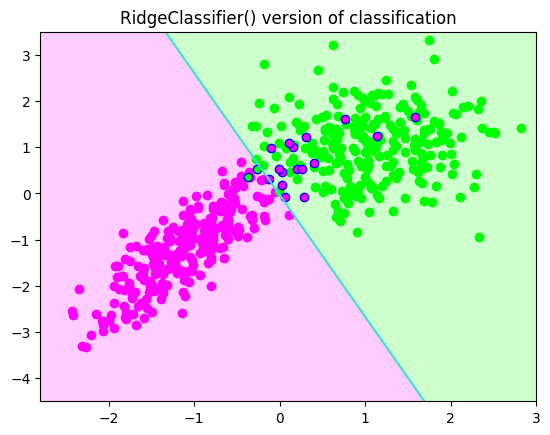

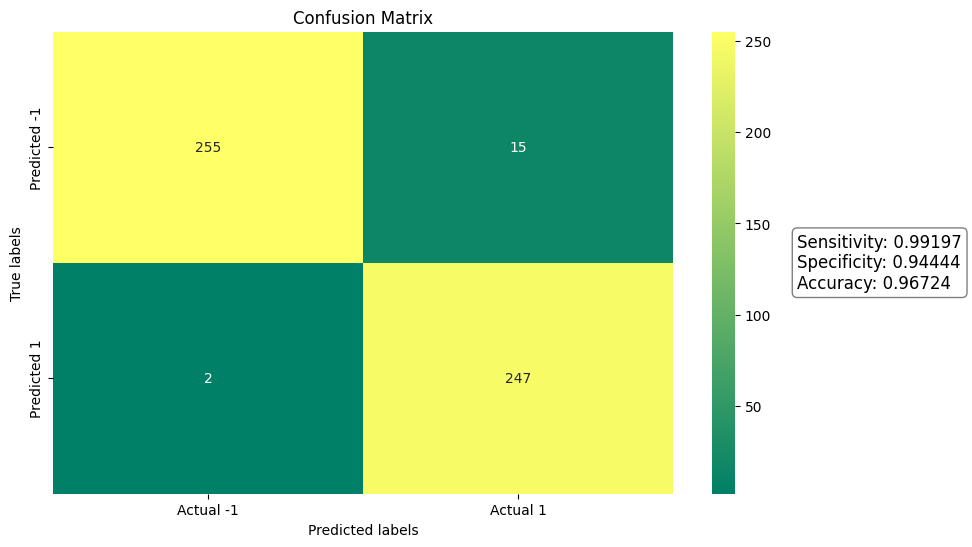

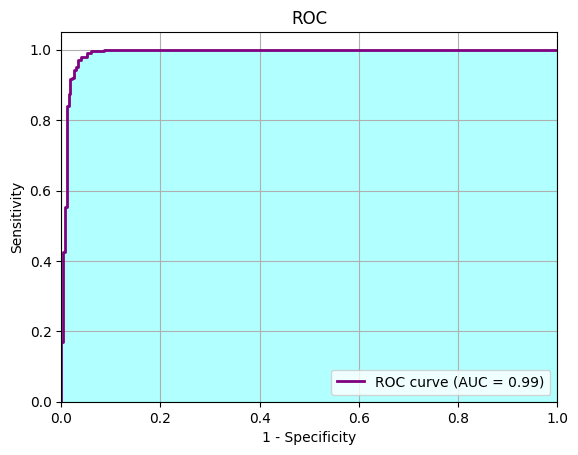

In [67]:
plot_classification_result(X_res, Theta, 'turquoise', 'magenta', 'lime', x, -2.8,3,-4.5,3.5, 'RidgeClassifier() version of classification')
plot_classification_summary(true_labels, predicted_labels)

classify: 0.0005497360s


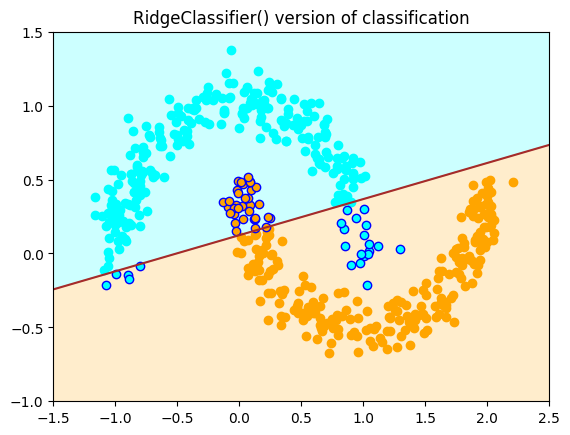

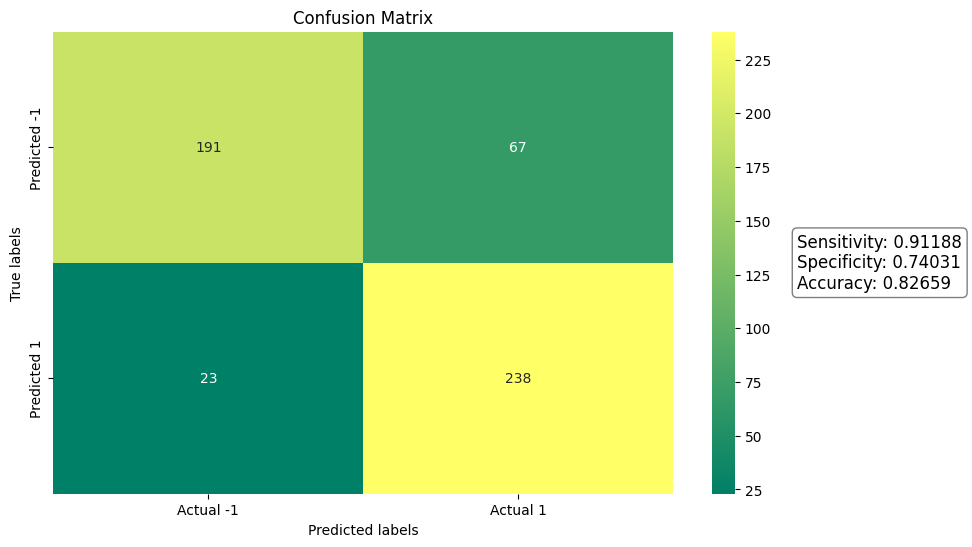

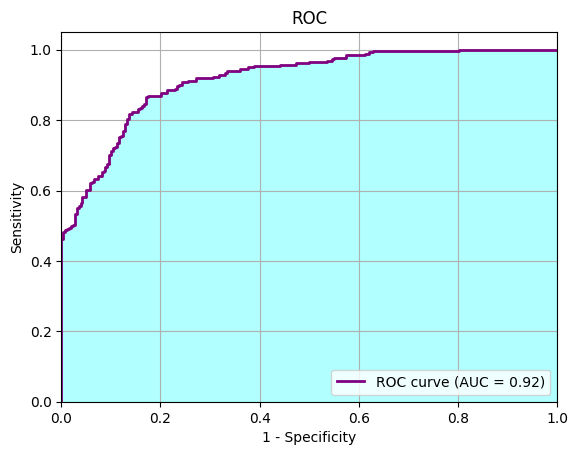

In [68]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_moons, t_train_moons)
coef = ridge_classifier.coef_[0]
intercept = ridge_classifier.intercept_

Theta = np.array([-coef[0], -coef[1], -intercept[0]])
X_test = [[X_test_moons[i][0], X_test_moons[i][1], -2*t_test_moons[i]+1] for i in range(len(X_test_moons))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]
plot_classification_result(X_res, Theta, 'brown', 'orange', 'cyan',x, -1.5, 2.5, -1, 1.5, 'RidgeClassifier() version of classification')
plot_classification_summary(true_labels, predicted_labels)

<font size="10">Choroby z Cleveland</font>

In [4]:
data = pd.read_csv('HeartCleveland.csv')
data.replace('?', pd.NA, inplace=True)
data.dropna(inplace=True)
data['target'] = data['target'].apply(lambda x: -1 if x != 0 else 1)

data = data.astype(float)
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,-1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,-1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,1.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,-1.0
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,-1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,-1.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,-1.0


In [ ]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.077441
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.998680
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,-1.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,-1.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


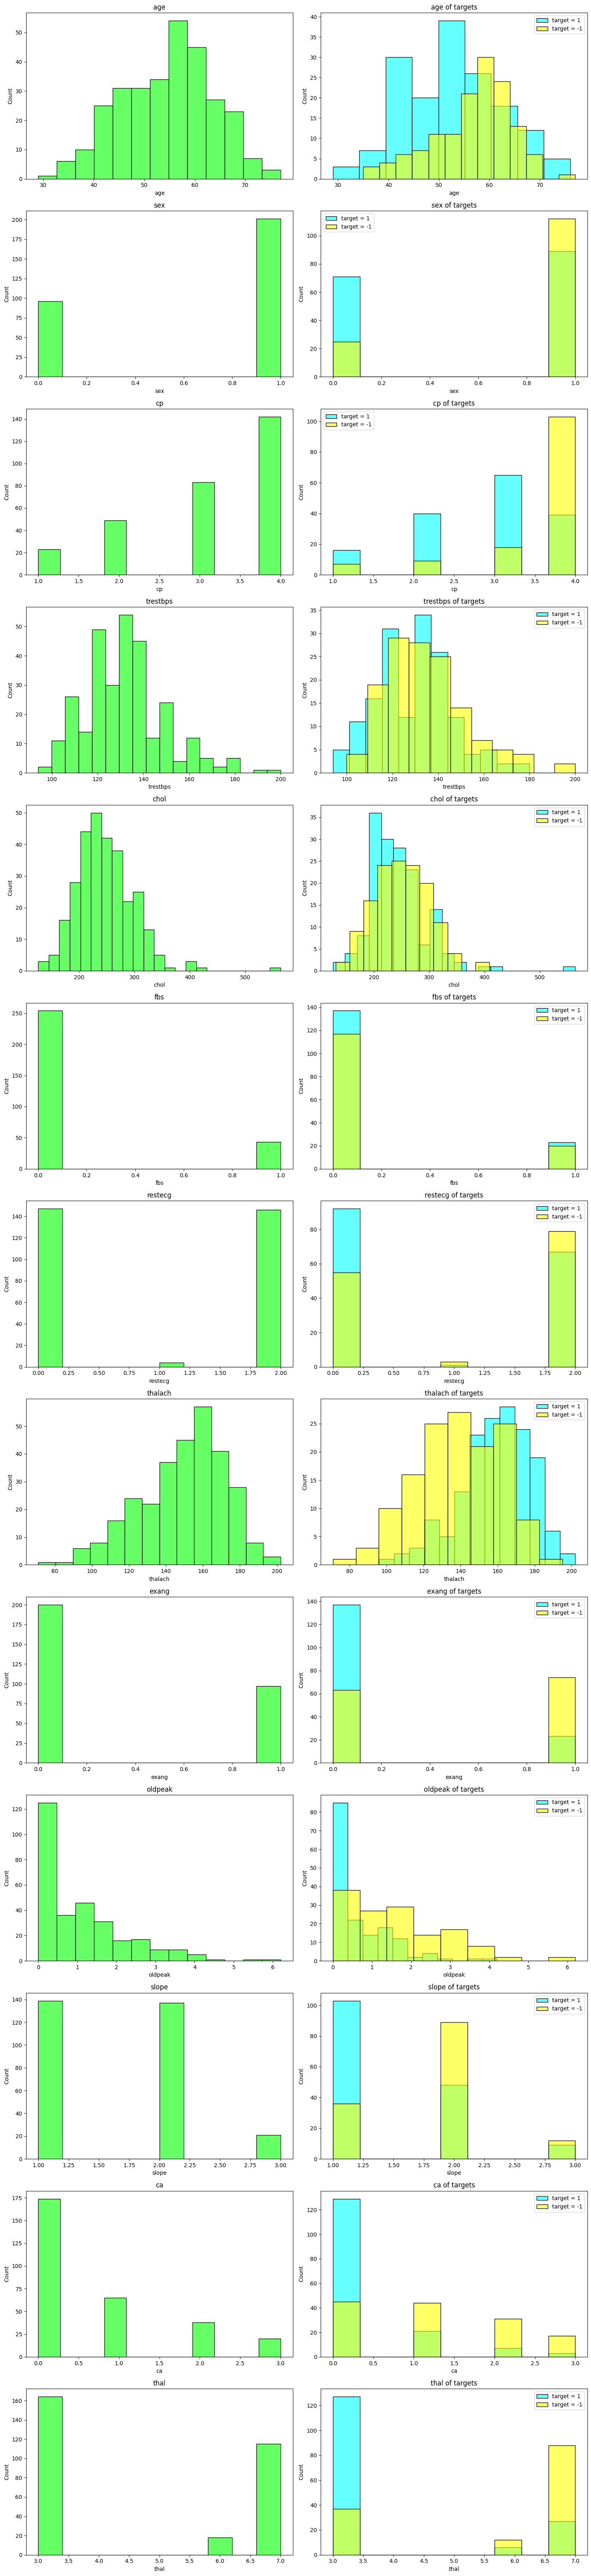

In [5]:
fig, axes = plt.subplots(len(data.columns) - 1, 2, figsize=(15, 5*(len(data.columns) - 1)))

for i, column in enumerate(data.columns):
    if column != 'target':
        sns.histplot(data[column], kde=False, ax=axes[i][0], color='lime', alpha=0.6)
        axes[i][0].set_title(f'{column}')
        sns.histplot(data[data['target'] == 1][column], color='cyan', kde=False, ax=axes[i][1], alpha=0.6)
        sns.histplot(data[data['target'] == -1][column], color='yellow', kde=False, ax=axes[i][1], alpha=0.6)
        axes[i][1].legend(['target = 1', 'target = -1'])
        axes[i][1].set_title(f'{column} of targets')

plt.tight_layout()
plt.show()

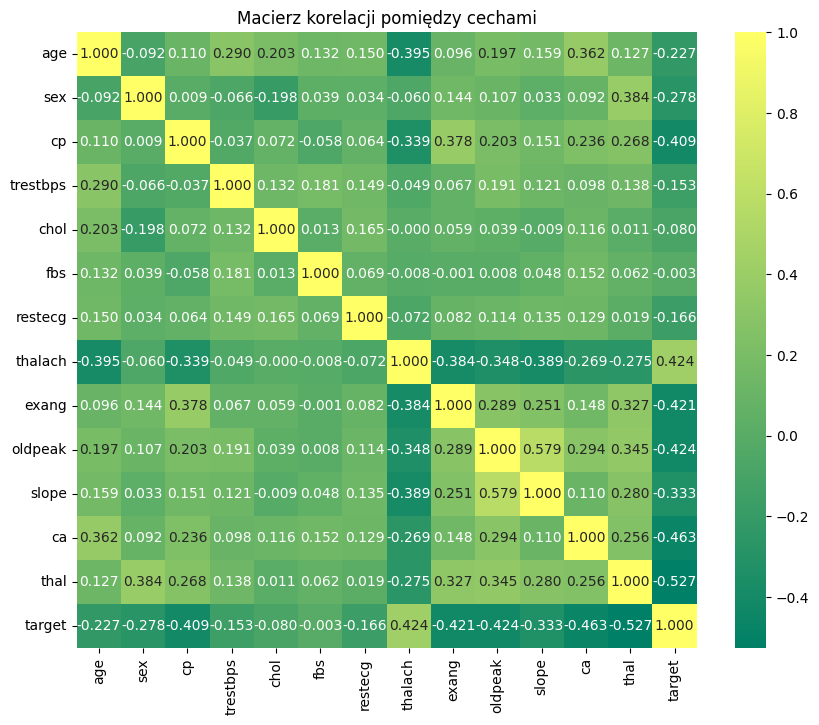

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt=".3f")
plt.title('Macierz korelacji pomiędzy cechami')
plt.show()


4 cechy pozwalające na najskuteczniejszą klasyfikację to thalach, oldpeak, ca, thal  (indeksy [7, 9, 11, 12])

In [ ]:
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:

X1 = np.array(X_train[y_train == -1])
X2 = np.array(X_train[y_train == 1])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1
Theta = np.linalg.inv(X.T@X)@X.T@t
X_test['one'] = 1
predicted_labels = np.array(X_test @ Theta.T)

true_labels = np.array(y_test)
Theta

array([ 1.30486080e-04, -2.95458994e-01, -1.75605535e-01, -2.49052054e-03,
       -3.01630736e-04,  2.42916755e-01, -4.72656145e-02,  4.55627364e-03,
       -3.18454396e-01, -9.05009796e-02, -1.10216169e-01, -2.54769786e-01,
       -1.26201204e-01,  1.70844838e+00])

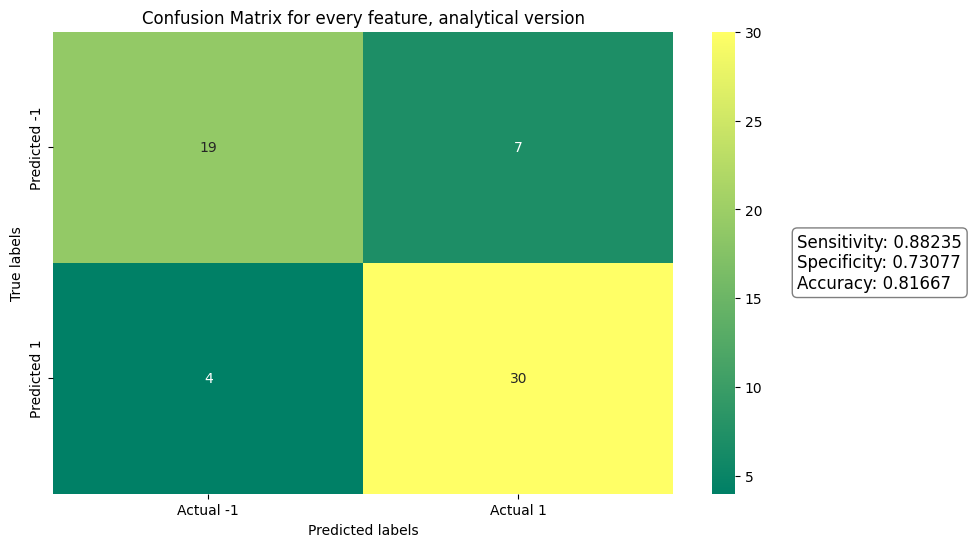

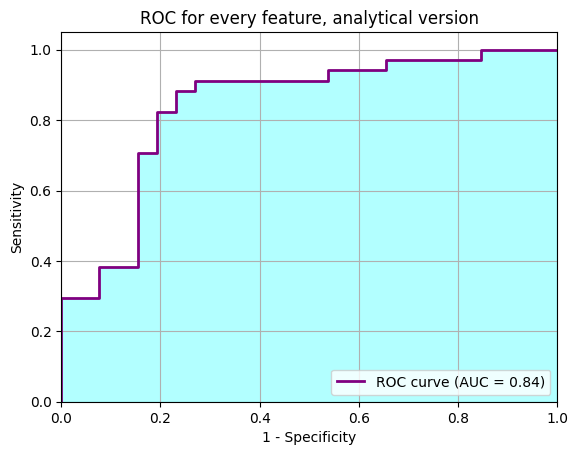

In [ ]:
plot_confusion_matrix(true_labels, np.sign(predicted_labels), cmap='summer', title='Confusion Matrix for every feature, analytical version')
plot_ROC(true_labels, predicted_labels, title='ROC for every feature, analytical version')

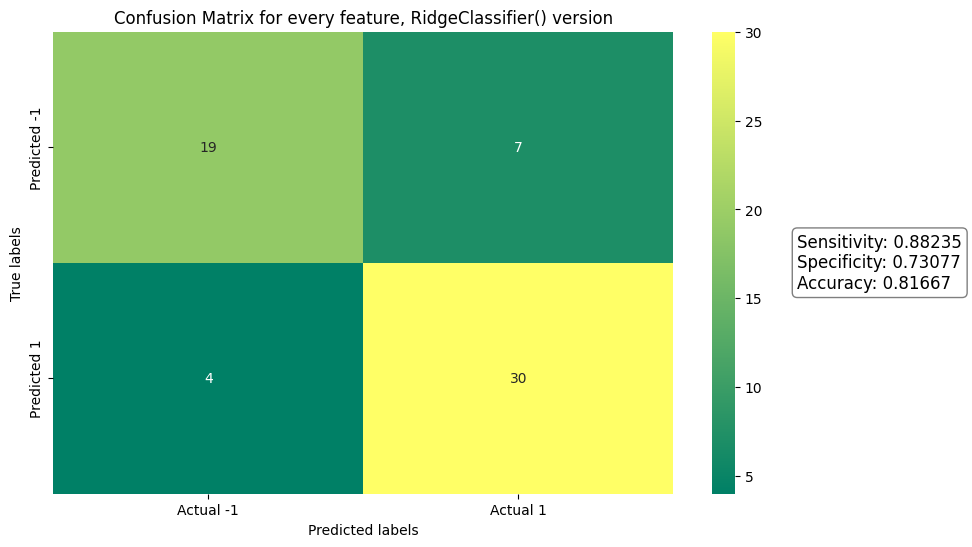

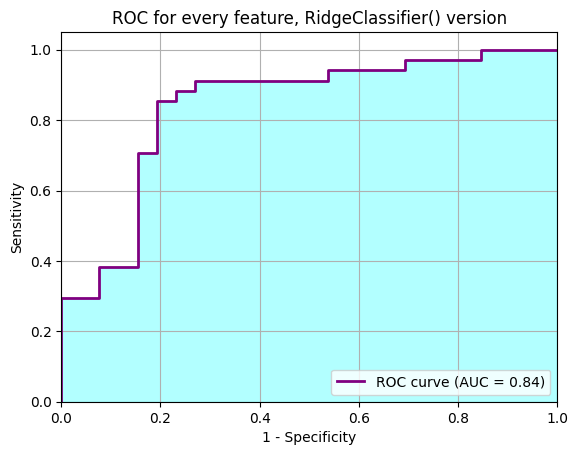

In [ ]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, y_train)
coef = ridge_classifier.coef_[0]
intercept = ridge_classifier.intercept_
Theta = np.concatenate((coef, intercept))
predicted_labels = np.array(X_test @ Theta.T)
true_labels = np.array(y_test)
plot_confusion_matrix(true_labels, np.sign(predicted_labels), cmap='summer', title='Confusion Matrix for every feature, RidgeClassifier() version')
plot_ROC(true_labels, predicted_labels, title='ROC for every feature, RidgeClassifier() version')


In [ ]:
clf = RidgeClassifier()
sfs = SequentialFeatureSelector(clf, n_features_to_select=4, direction='forward', scoring='f1', cv=5)
sfs.fit(X_train, y_train)
selected_feature_indices = sfs.get_support(indices=True)
print("Wybrane cechy:", selected_feature_indices)

Wybrane cechy: [ 8  9 11 12]


SFS wybrał cechy o indeksach [8, 9, 11, 12] (exang, oldpeak, ca, thal), a ja [7, 9, 11, 12] (thalach, oldpeak, ca, thal)

In [ ]:
X = data.drop('target', axis=1)
y = data['target']
X_sfs = X[['exang', 'oldpeak', 'ca', 'thal']] 
X_my = X[['thalach', 'oldpeak', 'ca', 'thal']] 
X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs = train_test_split(X_sfs, y, test_size=0.2, random_state=random_state)
X_train_my, X_test_my, y_train_my, y_test_my = train_test_split(X_my, y, test_size=0.2, random_state=random_state)

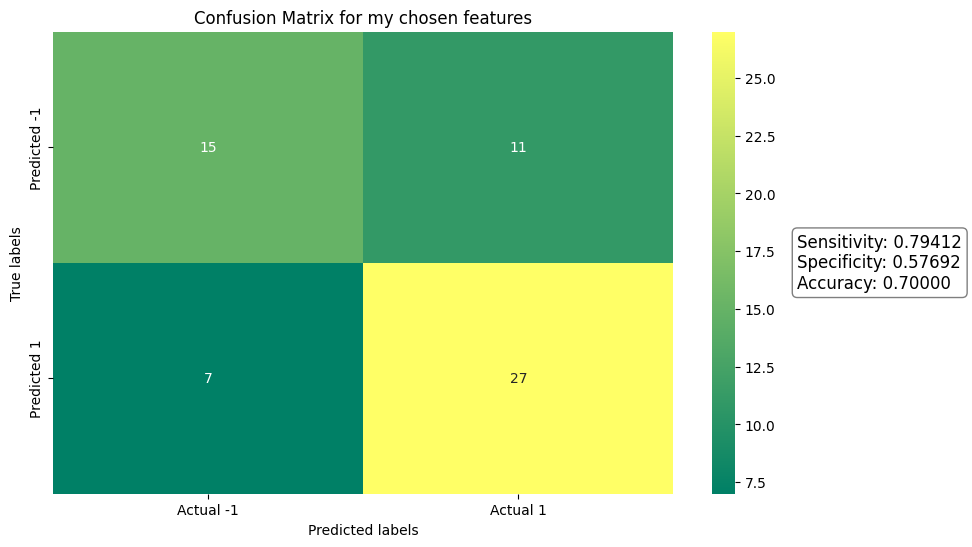

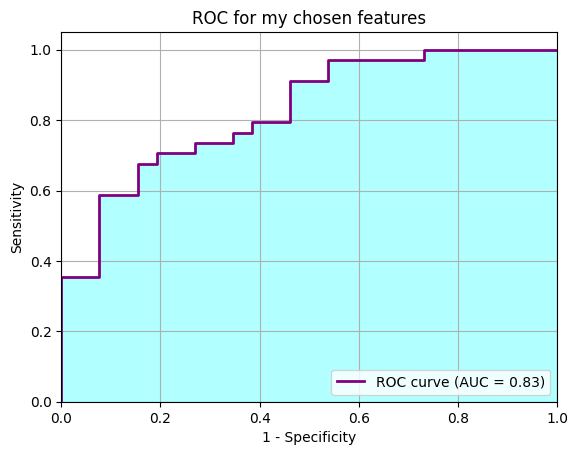

In [ ]:
X1 = np.array(X_train_my[y_train_my == -1])
X2 = np.array(X_train_my[y_train_my == 1])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1
Theta = np.linalg.inv(X.T@X)@X.T@t
X_test_my['target'] = 1
predicted_labels = np.array(X_test_my @ Theta.T)
true_labels = np.array(y_test)
plot_confusion_matrix(true_labels, np.sign(predicted_labels), cmap='summer', title='Confusion Matrix for my chosen features')
plot_ROC(true_labels, predicted_labels, title='ROC for my chosen features')

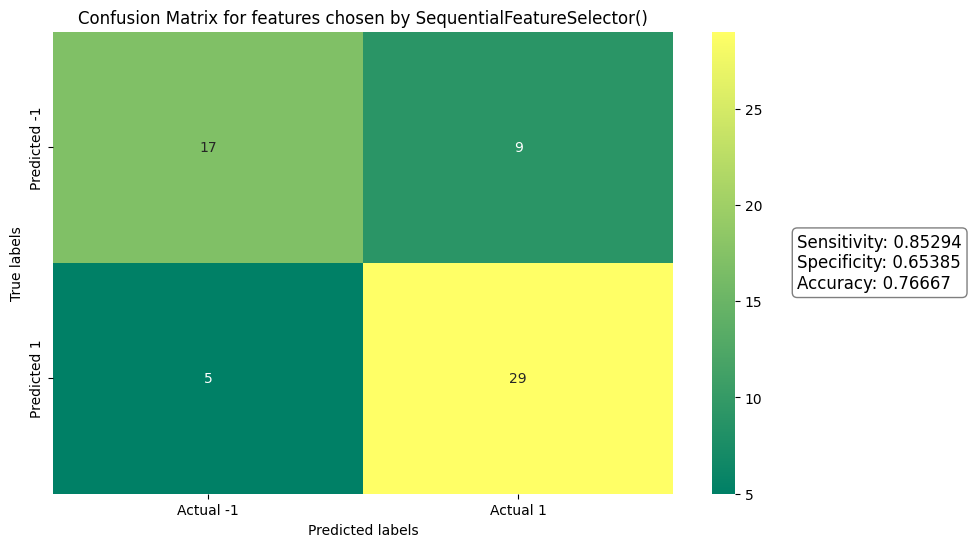

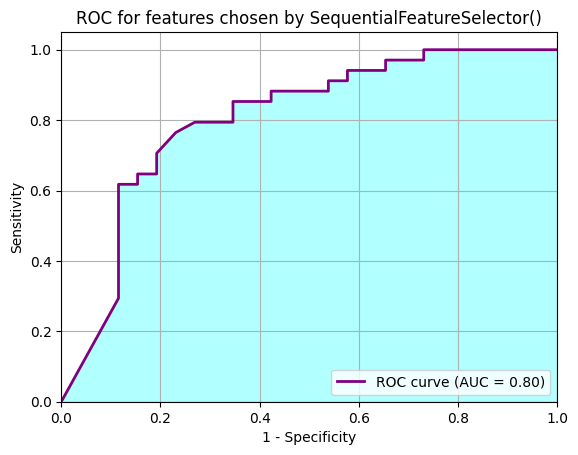

In [ ]:
X1 = np.array(X_train_sfs[y_train_sfs == -1])
X2 = np.array(X_train_sfs[y_train_sfs == 1])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1
Theta = np.linalg.inv(X.T@X)@X.T@t
X_test_sfs['target'] = 1
predicted_labels = np.array(X_test_sfs @ Theta.T)
true_labels = np.array(y_test)
plot_confusion_matrix(true_labels, np.sign(predicted_labels),cmap='summer', title='Confusion Matrix for features chosen by SequentialFeatureSelector()')
plot_ROC(true_labels, predicted_labels, title='ROC for features chosen by SequentialFeatureSelector()')